# Load packages

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import gumbel_r
from matplotlib.pyplot import cm
import math
import matplotlib
import matplotlib.colors as mcolors
from scipy.optimize import fsolve

import sympy
from sympy import *
from sympy import symbols, Eq, solve
from shapely.geometry import LineString


%matplotlib inline
plt.style.use('ggplot')
import warnings
from scipy.stats import pearsonr
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

output = 'Output34'
Input = 'Input4'

# Catchment descriptors

In [4]:
#Function to calculate HAI
def HAI_calculate(temp, precipitation):

    temp_adjusted = np.zeros(12)
    
    for i in range(1,13):
        if temp[i] < 0:
            temp_adjusted[i-1] = 0
        elif temp[i] > 30:
            temp_adjusted[i-1] = 30
        else:
            temp_adjusted[i-1] = temp[i]            
        
    T = np.sum(temp_adjusted)
    HAI = (58.93 * (T/12))/precipitation
    
    return HAI

#Function for the Seasonality Index
def Seasonality_index(Annual_mean, Monthly_mean):
    SI = (1/Annual_mean) * np.sum(np.abs(Monthly_mean - (Annual_mean/12)))
    return SI

#Function for Seasonality Timing Index
def ST_calc(dP,dT):
    days = 366
    ST = dP[0] * np.sign(dT[0]) * np.cos((np.pi * (dP[1] - dT[1]))/days)
    return ST

#Functions to compute Seasonal variability indexes
def T_daily(dT):
    t = np.linspace(1,366,366)
    days = 366
    T = T_mean + dT[0] * np.sin((2*np.pi * (t-dT[1]))/days)
    return T

def Cal_T_daily(dT):
    days = 366
    T_calc = T_daily(dT)
    
    return (np.sum(np.abs(T_calc - T_obs)))/days

def P_daily(dP):
    t = np.linspace(1,366,366)
    days = 366
    P = P_mean * (1 + dP[0] * np.sin((2*np.pi * (t-dP[1]))/days))
    return P

def Cal_P_daily(dP):
    days = 366
    P_calc = P_daily(dP)
    
    return (np.sum(np.abs(P_calc - P_obs)))/days

def E_daily(dE):
#    t = np.linspace(1,366,366)
    t = np.linspace(1,366,366)

    days = 366
    E = E_mean * (1 + dE[0] * np.sin((2*np.pi * (t-dE[1]))/days))
    return E

def Cal_E_daily(dE):
    days = 366
    E_calc = E_daily(dE)
    
    return (np.sum(np.abs(E_calc - E_obs)))/days

#Function for the interstorm duration or low_prec_freq
def Interstorm_duration(P):
    interstorm = []
    count = 0

    for j in range(len(P)):
        if P[j] < 1:
            count += 1
        elif P[j] >= 1 and count > 0:
            interstorm.append(count)
            count = 0 
    interstorm_duration = np.mean(interstorm)
    return interstorm_duration

"""
Adapted root-zone storage capacity descriptors
"""

#Function to compute the root-zone storage capacity over total time period

def rootzone(df_out, RP):
    firstyear = df_out['hydroyear'].iloc[0]
    lastyear = df_out['hydroyear'].iloc[-1]
    df_out = df_out.drop(df_out[df_out['hydroyear']==firstyear].index)
    df_out = df_out.drop(df_out[df_out['hydroyear']==lastyear].index)
    years = df_out.groupby(['hydroyear'])
    SD = years['SD_sum'].max() - years['SD_sum'].min()
    var = gumbel_r.fit(SD)
    p = 1-1/RP
    Sr = gumbel_r.ppf(p, var[0],var[1])
    return(Sr, df_out)


#Function to compute the potential evaporation for CAMELS-GB
def calc_Makkink_GB(Temp, Rs, timestep = 86400):
    """
    Rs is hier in W/m2
    om van straling unit knmi (J/cm2) naar W/m2 ----> Rs_unit_knmi * 2.77777 
	deze formule is van komt van: https://nl.wikipedia.org/wiki/Referentie-gewasverdamping 
    """
    a = 6.1078
    b = 17.294
    c = 237.73
    Eref = np.zeros(len(Temp))
    for i in range(len(Temp)):
        gamma=0.646+0.0006*Temp[i] 				#psychrometer constante (hPa/C)
        labda=1000*(2501-2.38*Temp[i])			#verdampingswarmte water (J/kg)
        Slope = (a*b*c) / (c+Temp[i])**2 * np.exp(b*Temp[i] / (c+Temp[i]))   # 
        Eref[i] = 0.65 * Slope / (Slope + gamma) * Rs[i] / labda * timestep     #ref verd in mm/h ! 
    return Eref


def w_function(AI, w):
    EI = 1 + AI - (1 + (AI**w))**(1/w)
    return EI

# Catchment selection 

In [5]:
"""
CAMELS-GB: Catchment selection
Check for human influence, if 'Y' this indicates a lot of human influence
Frac_snow < 0.1 means no insignificant snow impact
Saves the catchments to a list
"""

human_influence = pd.read_csv('1_Data\8344e4f3-d2ea-44f5-8afa-86d2987543a9\data\CAMELS_GB_humaninfluence_attributes.csv')
catch_attr = pd.read_csv('1_Data\8344e4f3-d2ea-44f5-8afa-86d2987543a9\data\CAMELS_GB_climatic_attributes.csv')

catchment_list_GB = []
for i in range(len(human_influence)):
    if (human_influence['benchmark_catch'][i] == 'Y')and (catch_attr['frac_snow'][i]<0.1):
        catchment_list_GB.append(human_influence['gauge_id'][i])
        

removing_GB = [27084, 39101, 44009, 81004, 2002, 66004, 60012, 83010, 90003, 96002, 16003, 18011, 21006, 3003, 27073, 39028, 39065, 42008, 44006, 81002, 85003, 4005, 72014, 83006, 84022, 95001, 73015]

for i in range(len(removing_GB)):
    catchment_list_GB.remove(removing_GB[i])

# Load data

## Determine time slices

In [6]:
yrcut = [1980, 1990, 2000, 2010] # het laatste jaar zit er niet in
colors = ['#9FB2FF', '#496AFF', '#0020AF', '#001678']
colors2 = ['#6CC24A','#FFB81C', '#A50034']
yrsl = []
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
print(yrsl)

['1980 - 1989', '1990 - 1999', '2000 - 2009']


## Loop through catchments

### Determine AI & ST total

In [7]:
catchment_list = catchment_list_GB
AI_total = []
ST_total = []

for i in range(len(catchment_list)):  
    # Import data and select right dates
    data = pd.read_csv('1_Data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/timeseries/CAMELS_GB_hydromet_timeseries_'+str(catchment_list[i])+str("_19701001-20150930.csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data[3379:-273]
    
    
    # Compute the Makkink potential evaporation
    Eref = calc_Makkink_GB(data['temperature'],data['shortwave_rad'])
    data['Ep_MAK'] = Eref
        
    # Compute mean values    
    Ep = data['Ep_MAK'].mean()    
    T = data['temperature'].mean()
    P  = data['precipitation'].mean()
    Q  = data['discharge_spec'].mean()
        
    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  
    AI = Ep / P   
    EI = Ea / P 
    
    
    #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['temperature'][k])+1):
            T1[count] = daily_sliced_mean['temperature'][k,m]
            P1[count] = daily_sliced_mean['precipitation'][k,m]
            E1[count] = daily_sliced_mean['Ep_MAK'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366

    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
        
    AI_total.append(AI)
    ST_total.append(ST)


### Calculate AI & ST cuts

In [25]:
ngroup_AI = round(len(AI_total)/3)
AI_total.sort()
cut1_AI = AI_total[ngroup_AI-1]
cut2_AI = AI_total[2*ngroup_AI-1]

ngroup_ST = round(len(ST_total)/3)
ST_total.sort()
cut1_ST = ST_total[ngroup_ST-1]
cut2_ST = ST_total[2*ngroup_ST-1]
max_ST = max(ST_total)
min_ST = min(ST_total)

print(cut1_AI)
print(cut2_AI)

min_AI = min(AI_total)
max_AI = max(AI_total)

0.40981797824599475
0.6714727636302663


### Loop 

In [26]:
warnings.filterwarnings('ignore')
catchment_list = catchment_list_GB
df_output = pd.DataFrame(index=catchment_list)
catchment_list_arid = []
catchment_list_med = []
catchment_list_wet = []
catchment_list_STlow = []
catchment_list_STmed = []
catchment_list_SThigh = []

for i in range(len(catchment_list)):  
    # Import data and select right dates
    data = pd.read_csv('1_Data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/timeseries/CAMELS_GB_hydromet_timeseries_'+str(catchment_list[i])+str("_19701001-20150930.csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data[3379:-273]
    
    # Compute the Makkink potential evaporation
    Eref = calc_Makkink_GB(data['temperature'],data['shortwave_rad'])
    data['Ep_MAK'] = Eref
        
    # Compute mean values    
    Ep = data['Ep_MAK'].mean()    
    T = data['temperature'].mean()
    P  = data['precipitation'].mean()
    Q  = data['discharge_spec'].mean()
        
    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  
    AI = Ep / P   
    EI = Ea / P 
    
    # Calculate root zone storage deficits
    RP    = 20 # Return-period of 20 years
    P_ts  = data['precipitation']
    EP_ts = data['Ep_MAK']

    Et = np.zeros(len(P_ts))
    SD = np.zeros(len(P_ts))

    for z in range(len(P_ts)):
        Et[z] = (EP_ts[z]/Ep) * Ea
        if z == 0:
            SD[z] = min(0, P_ts[z] - Et[z])
        else:
            SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
    data.loc[:,'SD'] = SD
            
    data['year'] = pd.DatetimeIndex(data['date']).year
    df_out = pd.DataFrame(index = data.index)
    df_out['hydroyear'] = data['year']
    df_out['SD_sum'] = data['SD']
    Sr = rootzone(df_out,RP)[0]    
    
    #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['temperature'][k])+1):
            T1[count] = daily_sliced_mean['temperature'][k,m]
            P1[count] = daily_sliced_mean['precipitation'][k,m]
            E1[count] = daily_sliced_mean['Ep_MAK'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366

    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    
    
    if AI <= cut1_AI:
        catchment_list_wet.append(catchment_list[i])
    elif cut1_AI <= AI <= cut2_AI:
        catchment_list_med.append(catchment_list[i])
    elif cut2_AI < AI:
        catchment_list_arid.append(catchment_list[i])
        
        
    if ST <= cut1_ST:
        catchment_list_STlow.append(catchment_list[i])
    elif cut1_ST <= ST <= cut2_ST:
        catchment_list_STmed.append(catchment_list[i])
    elif cut2_ST < ST:
        catchment_list_SThigh.append(catchment_list[i])
    
    if AI < EI or Ea < 0:
        print(f'Exclude catchment with ID {catchment_list[i]}')
        
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    df_output.loc[catchment_list[i],[f'AI']] = AI
    df_output.loc[catchment_list[i],[f'EI']] = EI
    df_output.loc[catchment_list[i],[f'Sr']] = Sr
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['date']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_MAK'].mean()    
        T = datanew['temperature'].mean()
        P  = datanew['precipitation'].mean()
        Q  = datanew['discharge_spec'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
            
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                                
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize=5)
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['precipitation']
        EP_ts = datanew['Ep_MAK']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
            
        datanew['year'] = pd.DatetimeIndex(datanew['date']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        Sr = rootzone(df_out,RP)[0]

        #Annual precipitation values
        data_y = datanew.resample('A').sum()
        Pa = data_y['precipitation'].mean()
       
        #monthly_mean_values:
        data_m_sum = datanew.resample('M').sum()
        monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
        P_m_sum = np.zeros(12)
        P_m_sum = monthly_sliced_sum['precipitation']
        
        data_m_mean = datanew.resample('M').mean()
        monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
        T_m_mean = np.zeros(12)
        T_m_mean = monthly_sliced_mean['temperature']
        
        
        #Compute the seasonality variability indexes
        data_d = datanew.resample('d').mean().bfill()
        daily_sliced_mean = datanew.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
        T1 = np.zeros((366))
        P1 = np.zeros((366))
        E1 = np.zeros((366))
        count = 0

    
        for k in range(1,13):
            for m in range(1,len(daily_sliced_mean['temperature'][k])+1):
                T1[count] = daily_sliced_mean['temperature'][k,m]
                P1[count] = daily_sliced_mean['precipitation'][k,m]
                E1[count] = daily_sliced_mean['Ep_MAK'][k,m]
                count += 1
        t = np.linspace(1,366,366)
    
        T_obs = T1
        P_obs = P1
        E_obs = E1

        T_mean = np.nanmean(T_obs)
        P_mean = np.nanmean(P_obs)
        E_mean = np.nanmean(E_obs)

        x0_T = [5, 110]
        x0_P = [0.3, 40]
        x0_E = [0.4, 40]
        lb = [0, np.inf]
        ub = [0, 366]
    
        res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
        res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
        res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

        dp = res_P.x[0]
        sp = res_P.x[1] / 366
        dt = res_T.x[0]
        st = res_T.x[1] / 366
        
        if abs(sp - st) <= 0.5:
            sd = sp - st

        elif (sp - st) > 0.5:
            sd = -1 + (sp - st)

        else:
            sd = 1 + (sp - st)

        de = res_E.x[0]
        se = res_E.x[1] / 366

        # Compute variables
        ST = ST_calc(res_P.x,res_T.x)
        HAI = HAI_calculate(T_m_mean, Pa)
        SI = Seasonality_index(Pa, P_m_sum)
        is_dur = Interstorm_duration(datanew['precipitation'])
            
        # Save to Output 
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w
        df_output.loc[catchment_list[i],[f'P {yrsl[j]}']] = P
        df_output.loc[catchment_list[i],[f'Ep {yrsl[j]}']] = Ep
        df_output.loc[catchment_list[i],[f'T {yrsl[j]}']] = T     
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'SI {yrsl[j]}']] = SI
        df_output.loc[catchment_list[i],[f'HAI {yrsl[j]}']] = HAI
        df_output.loc[catchment_list[i],[f'is_dur {yrsl[j]}']] = is_dur
        df_output.loc[catchment_list[i],[f'dp {yrsl[j]}']] = dp
        df_output.loc[catchment_list[i],[f'sp {yrsl[j]}']] = sp
        df_output.loc[catchment_list[i],[f'dt {yrsl[j]}']] = dt
        df_output.loc[catchment_list[i],[f'st {yrsl[j]}']] = st
        df_output.loc[catchment_list[i],[f'sd {yrsl[j]}']] = sd
        df_output.loc[catchment_list[i],[f'de {yrsl[j]}']] = de
        df_output.loc[catchment_list[i],[f'se {yrsl[j]}']] = se
        df_output.loc[catchment_list[i],[f'ST {yrsl[j]}']] = ST
        df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']] = Sr
            
            
    axs[0].legend(loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments/Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)
    
display(df_output)

,AI,EI,Sr,AI 1980 - 1989,EI 1980 - 1989,omega 1980 - 1989,P 1980 - 1989,Ep 1980 - 1989,T 1980 - 1989,SI 1980 - 1989,...,is_dur 2000 - 2009,dp 2000 - 2009,sp 2000 - 2009,dt 2000 - 2009,st 2000 - 2009,sd 2000 - 2009,de 2000 - 2009,se 2000 - 2009,ST 2000 - 2009,Sr actual 2000 - 2009
102001,0.502179,0.437409,198.224781,0.480026,0.458716,3.500533,3.091689,1.484091,9.425201,0.295626,...,3.199686,0.404071,0.628280,5.336733,0.328164,0.300116,0.906374,0.225619,0.237389,178.495404
11004,0.498198,0.405638,126.827201,0.516851,0.353662,1.780319,2.400794,1.240854,7.039080,0.172386,...,3.233385,0.159075,0.573614,5.372030,0.325849,0.247765,0.974394,0.228020,0.113270,116.155984
13004,0.345895,0.249098,82.443858,0.350360,0.300435,2.116602,3.495639,1.224733,5.867356,0.242518,...,3.138843,0.263540,0.648324,5.491548,0.323034,0.325290,0.934018,0.226932,0.137495,56.524957
15023,0.302020,0.271731,121.927584,0.311013,0.238781,1.748777,3.819469,1.187903,6.106466,0.285695,...,3.269896,0.317036,0.657763,5.459778,0.323683,0.334080,0.969450,0.225737,0.157874,121.432439
15025,0.356019,0.231054,62.666666,0.368762,0.227566,1.512615,3.218415,1.186828,5.765275,0.247232,...,3.147009,0.255822,0.663988,5.457085,0.322916,0.341072,0.957974,0.226375,0.122488,53.943073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79002,0.299271,0.250955,101.167702,0.303563,0.247696,1.873162,4.213515,1.279067,7.232842,0.288852,...,3.137112,0.354906,0.658093,5.519755,0.322293,0.335800,0.951026,0.226497,0.175066,90.610722
79004,0.272360,0.240567,111.009490,0.279028,0.238378,1.964798,4.669258,1.302853,7.105834,0.291025,...,3.257885,0.387605,0.647321,5.534234,0.322754,0.324568,0.934625,0.226123,0.202972,89.025353
8009,0.395421,0.311196,93.205173,0.402179,0.292794,1.762664,2.831484,1.138762,5.579781,0.207901,...,2.928571,0.328777,0.701471,5.293598,0.323371,0.378101,0.988773,0.225022,0.122853,83.465089
93001,0.145721,0.128872,64.376444,0.140499,0.133015,2.111319,7.712456,1.083592,6.341188,0.358308,...,2.752155,0.496230,0.714992,4.968028,0.326194,0.388797,0.996042,0.220961,0.169855,55.911969


# Calculate changes and output

## Calculate changes

In [27]:
descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Holdrigde Aridity Index', 'Interstorm duration', 'dp', 'sp', 'dt', 'st', 'sd', 'de', 'se', 'Seasonality Timing Index']
descriptors = ['P', 'Ep', 'T', 'AI', 'SI', 'HAI', 'is_dur', 'dp', 'sp', 'dt', 'st', 'sd', 'de', 'se', 'ST']

for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI_exp - EI
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
            
display(df_output)

,AI,EI,Sr,AI 1980 - 1989,EI 1980 - 1989,omega 1980 - 1989,P 1980 - 1989,Ep 1980 - 1989,T 1980 - 1989,SI 1980 - 1989,...,HAI_change 2000 - 2009,is_dur_change 2000 - 2009,dp_change 2000 - 2009,sp_change 2000 - 2009,dt_change 2000 - 2009,st_change 2000 - 2009,sd_change 2000 - 2009,de_change 2000 - 2009,se_change 2000 - 2009,ST_change 2000 - 2009
102001,0.502179,0.437409,198.224781,0.480026,0.458716,3.500533,3.091689,1.484091,9.425201,0.295626,...,-0.045446,0.056611,0.083800,-0.062796,0.023088,0.006052,-0.068847,-0.030630,-0.010599,0.109237
11004,0.498198,0.405638,126.827201,0.516851,0.353662,1.780319,2.400794,1.240854,7.039080,0.172386,...,-0.031464,-0.204800,-0.094258,0.022719,0.142839,0.008064,0.014654,-0.011880,-0.003312,-0.075112
13004,0.345895,0.249098,82.443858,0.350360,0.300435,2.116602,3.495639,1.224733,5.867356,0.242518,...,0.004931,-0.093300,-0.122075,-0.066803,0.079767,0.007544,-0.074347,-0.020354,-0.005533,0.017915
15023,0.302020,0.271731,121.927584,0.311013,0.238781,1.748777,3.819469,1.187903,6.106466,0.285695,...,0.009791,-0.190139,-0.147433,-0.092535,0.000364,0.009058,-0.101593,-0.024115,-0.008813,0.064647
15025,0.356019,0.231054,62.666666,0.368762,0.227566,1.512615,3.218415,1.186828,5.765275,0.247232,...,0.007337,-0.209767,-0.192819,-0.063254,0.057351,0.007361,-0.070615,-0.011725,-0.007153,-0.000394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79002,0.299271,0.250955,101.167702,0.303563,0.247696,1.873162,4.213515,1.279067,7.232842,0.288852,...,0.012043,-0.249607,-0.121018,-0.078569,0.008840,0.008366,-0.086936,-0.018702,-0.009685,0.060675
79004,0.272360,0.240567,111.009490,0.279028,0.238378,1.964798,4.669258,1.302853,7.105834,0.291025,...,0.001968,-0.130577,-0.098915,-0.090151,0.012761,0.009054,-0.099205,-0.021811,-0.010925,0.087573
8009,0.395421,0.311196,93.205173,0.402179,0.292794,1.762664,2.831484,1.138762,5.579781,0.207901,...,0.008132,-0.303907,-0.004608,-0.039623,0.041732,0.006218,-0.045841,-0.005643,-0.008687,0.043948
93001,0.145721,0.128872,64.376444,0.140499,0.133015,2.111319,7.712456,1.083592,6.341188,0.358308,...,0.014862,-0.224535,0.024552,-0.032895,0.039421,0.003616,-0.036511,-0.004488,-0.009878,0.060188


## Calculate expected Sr

In [28]:
warnings.filterwarnings('ignore')
catchment_list = catchment_list_GB

for i in range(len(catchment_list)):  
    # Import data and select right dates
    data = pd.read_csv('1_Data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/timeseries/CAMELS_GB_hydromet_timeseries_'+str(catchment_list[i])+str("_19701001-20150930.csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data[3379:-273]
    
    # Compute the Makkink potential evaporation
    Eref = calc_Makkink_GB(data['temperature'],data['shortwave_rad'])
    data['Ep_MAK'] = Eref
        
    # Compute mean values    
    Ep = data['Ep_MAK'].mean()    
    T = data['temperature'].mean()
    P  = data['precipitation'].mean()
    Q  = data['discharge_spec'].mean()
        
    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  
    AI = Ep / P   
    EI = Ea / P 
    
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['date']).year
    for j in range(len(yrsl)):
        if j > 0:            
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]

            # Compute the Makkink potential evaporation
            Ep = datanew['Ep_MAK'].mean()    
            T = datanew['temperature'].mean()
            P  = datanew['precipitation'].mean()

            # Compute actual evaporation and Evaporative Index and Aridity index
            AI = Ep / P   
            EI = Ea / P 

            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()

            Ea_exp = EI_exp * P

            # Calculate root zone storage deficits
            RP    = 20 # Return-period of 20 years
            P_ts  = datanew['precipitation']
            EP_ts = datanew['Ep_MAK']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD


            datanew['year'] = pd.DatetimeIndex(datanew['date']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]

            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr

display(df_output)

,AI,EI,Sr,AI 1980 - 1989,EI 1980 - 1989,omega 1980 - 1989,P 1980 - 1989,Ep 1980 - 1989,T 1980 - 1989,SI 1980 - 1989,...,dp_change 2000 - 2009,sp_change 2000 - 2009,dt_change 2000 - 2009,st_change 2000 - 2009,sd_change 2000 - 2009,de_change 2000 - 2009,se_change 2000 - 2009,ST_change 2000 - 2009,Sr expected 1990 - 1999,Sr expected 2000 - 2009
102001,0.502179,0.437409,198.224781,0.480026,0.458716,3.500533,3.091689,1.484091,9.425201,0.295626,...,0.083800,-0.062796,0.023088,0.006052,-0.068847,-0.030630,-0.010599,0.109237,213.438401,186.489449
11004,0.498198,0.405638,126.827201,0.516851,0.353662,1.780319,2.400794,1.240854,7.039080,0.172386,...,-0.094258,0.022719,0.142839,0.008064,0.014654,-0.011880,-0.003312,-0.075112,103.849128,131.156855
13004,0.345895,0.249098,82.443858,0.350360,0.300435,2.116602,3.495639,1.224733,5.867356,0.242518,...,-0.122075,-0.066803,0.079767,0.007544,-0.074347,-0.020354,-0.005533,0.017915,130.124089,91.980654
15023,0.302020,0.271731,121.927584,0.311013,0.238781,1.748777,3.819469,1.187903,6.106466,0.285695,...,-0.147433,-0.092535,0.000364,0.009058,-0.101593,-0.024115,-0.008813,0.064647,106.792541,110.040599
15025,0.356019,0.231054,62.666666,0.368762,0.227566,1.512615,3.218415,1.186828,5.765275,0.247232,...,-0.192819,-0.063254,0.057351,0.007361,-0.070615,-0.011725,-0.007153,-0.000394,66.021730,47.034371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79002,0.299271,0.250955,101.167702,0.303563,0.247696,1.873162,4.213515,1.279067,7.232842,0.288852,...,-0.121018,-0.078569,0.008840,0.008366,-0.086936,-0.018702,-0.009685,0.060675,103.407350,78.708026
79004,0.272360,0.240567,111.009490,0.279028,0.238378,1.964798,4.669258,1.302853,7.105834,0.291025,...,-0.098915,-0.090151,0.012761,0.009054,-0.099205,-0.021811,-0.010925,0.087573,114.683690,90.127075
8009,0.395421,0.311196,93.205173,0.402179,0.292794,1.762664,2.831484,1.138762,5.579781,0.207901,...,-0.004608,-0.039623,0.041732,0.006218,-0.045841,-0.005643,-0.008687,0.043948,97.926063,92.032729
93001,0.145721,0.128872,64.376444,0.140499,0.133015,2.111319,7.712456,1.083592,6.341188,0.358308,...,0.024552,-0.032895,0.039421,0.003616,-0.036511,-0.004488,-0.009878,0.060188,74.395465,57.777775


## Calculate Sr change

In [29]:
for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            
display(df_output)

,AI,EI,Sr,AI 1980 - 1989,EI 1980 - 1989,omega 1980 - 1989,P 1980 - 1989,Ep 1980 - 1989,T 1980 - 1989,SI 1980 - 1989,...,dt_change 2000 - 2009,st_change 2000 - 2009,sd_change 2000 - 2009,de_change 2000 - 2009,se_change 2000 - 2009,ST_change 2000 - 2009,Sr expected 1990 - 1999,Sr expected 2000 - 2009,Sr deviation 1990 - 1999,Sr deviation 2000 - 2009
102001,0.502179,0.437409,198.224781,0.480026,0.458716,3.500533,3.091689,1.484091,9.425201,0.295626,...,0.023088,0.006052,-0.068847,-0.030630,-0.010599,0.109237,213.438401,186.489449,-38.771076,-7.994046
11004,0.498198,0.405638,126.827201,0.516851,0.353662,1.780319,2.400794,1.240854,7.039080,0.172386,...,0.142839,0.008064,0.014654,-0.011880,-0.003312,-0.075112,103.849128,131.156855,63.787208,-15.000870
13004,0.345895,0.249098,82.443858,0.350360,0.300435,2.116602,3.495639,1.224733,5.867356,0.242518,...,0.079767,0.007544,-0.074347,-0.020354,-0.005533,0.017915,130.124089,91.980654,-3.122324,-35.455697
15023,0.302020,0.271731,121.927584,0.311013,0.238781,1.748777,3.819469,1.187903,6.106466,0.285695,...,0.000364,0.009058,-0.101593,-0.024115,-0.008813,0.064647,106.792541,110.040599,42.646332,11.391841
15025,0.356019,0.231054,62.666666,0.368762,0.227566,1.512615,3.218415,1.186828,5.765275,0.247232,...,0.057351,0.007361,-0.070615,-0.011725,-0.007153,-0.000394,66.021730,47.034371,3.333204,6.908703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79002,0.299271,0.250955,101.167702,0.303563,0.247696,1.873162,4.213515,1.279067,7.232842,0.288852,...,0.008840,0.008366,-0.086936,-0.018702,-0.009685,0.060675,103.407350,78.708026,4.420531,11.902696
79004,0.272360,0.240567,111.009490,0.279028,0.238378,1.964798,4.669258,1.302853,7.105834,0.291025,...,0.012761,0.009054,-0.099205,-0.021811,-0.010925,0.087573,114.683690,90.127075,10.211961,-1.101722
8009,0.395421,0.311196,93.205173,0.402179,0.292794,1.762664,2.831484,1.138762,5.579781,0.207901,...,0.041732,0.006218,-0.045841,-0.005643,-0.008687,0.043948,97.926063,92.032729,32.848673,-8.567641
93001,0.145721,0.128872,64.376444,0.140499,0.133015,2.111319,7.712456,1.083592,6.341188,0.358308,...,0.039421,0.003616,-0.036511,-0.004488,-0.009878,0.060188,74.395465,57.777775,-0.090641,-1.865806


## Save output

In [30]:
df_output.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/GB.csv')

# Plots results

## Histogram EI deviations

### Histogram EI deviations per time slice

1
2


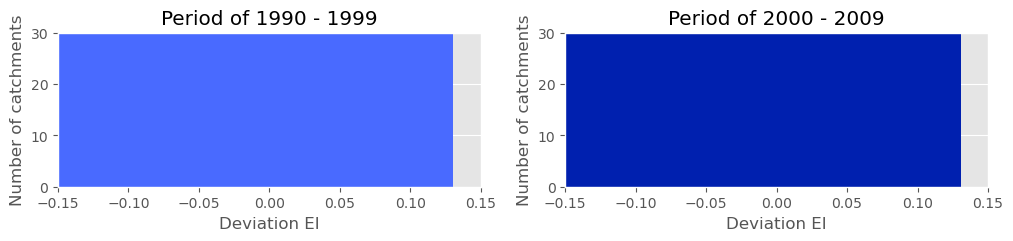

In [31]:
n_tot = len(yrsl) - 1 
fig, axs = plt.subplots(1, n_tot, figsize=(12,2))
# plt.suptitle('CAMELS GB')

for j in range(len(yrsl)):
    if j > 0:
        print(j)
        yr = yrsl[j]
        c = colors[j]
        n = j - 1
        df_output.plot.hist(column=[f'EI deviation {yr}'], bins=1000,color=c, ax=axs[n], ylim=(0,30), xlim=(-0.15,0.15))
        axs[n].set_xlabel("Deviation EI")
        axs[n].set_ylabel("Number of catchments")
        axs[n].set_title(f"Period of {yr}")
        axs[n].get_legend().remove()
    
plt.savefig(f'2_Output/{output}/Histograms/Histograms_EI_per_time_slice.png')   
# plt.close(fig)

### Histogram EI deviations combined time periods (overlapping)

<Figure size 700x500 with 0 Axes>

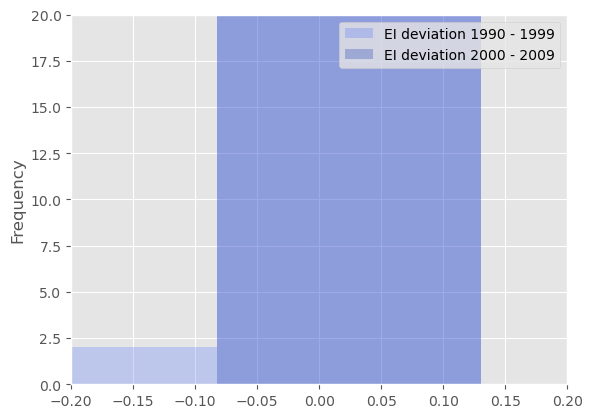

In [32]:
"Histogram EI deviations combined time periods (overlapping)"
for j in range(len(yrsl)):
        if j > 0:
            yr = yrsl[j]
            c = colors[j]
            n = j - 1

        

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(7)
              
df_output.plot.hist(column=[f'EI deviation {yrsl[1]}', f'EI deviation {yrsl[2]}'], bins=2000, color=[colors[1], colors[2]], alpha=0.25, ylim=(0,20), xlim=(-0.2,0.2))


plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_overlapping_v1.png')   
# plt.close(fig)

### Histogram EI deviations combined time periods (not overlapping)

[102001    0.044083
11004    -0.108529
13004     0.004002
15023    -0.053440
15025    -0.006210
            ...   
79002    -0.005436
79004    -0.012073
8009     -0.044423
93001     0.000123
94001    -0.021364
Name: EI deviation 1990 - 1999, Length: 104, dtype: float64, 102001    0.011275
11004     0.024692
13004     0.066624
15023    -0.013457
15025    -0.017935
            ...   
79002    -0.016545
79004     0.001616
8009      0.013798
93001     0.003558
94001    -0.008873
Name: EI deviation 2000 - 2009, Length: 104, dtype: float64]


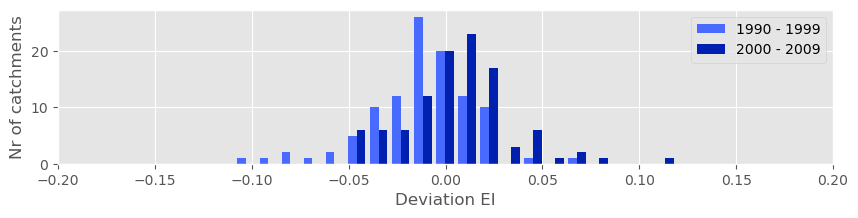

In [33]:
"Histogram EI deviations combined time periods (not overlapping)"
              
fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(10)
EI_dev_grouped = ["", ""]


        
for j in range(len(yrsl)):  
    if j > 0:
        EI_dev = df_output[f'EI deviation {yrsl[j]}']
        EI_dev_grouped[j-1] = EI_dev
        
print(EI_dev_grouped)
        

plt.hist(EI_dev_grouped, bins=20, alpha = 1, color = colors[1:3], label=yrsl[1:3])        
plt.xlim(-0.2, 0.2)
plt.xlabel('Deviation EI')
plt.ylabel('Nr of catchments')
# legend_el = [Patch(color=colors[0], label='Period 1'),
#              Patch(color=colors[1], label='Period 2'),
#              Patch(color=colors[2], label='Period 3')]

# plt.legend(handles=legend_el)

plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_years_notoverlapping_v1.png')   

### Histogram EI deviations grouped by aridity (overlapping)

0
1
2


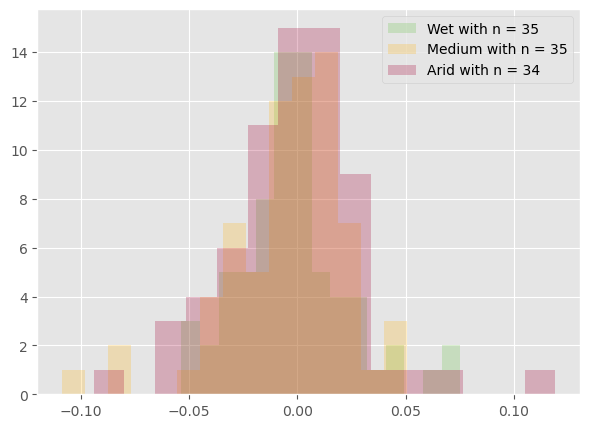

In [34]:
"Histogram EI deviations grouped by aridity (overlapping)"

aridities = ["Wet", "Medium", "Arid"]

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(7)

for a in range(len(aridities)):
    print(a)
    EI_dev_total = []
    if a == 0:
        catchment_list = catchment_list_wet
    elif a == 1:
        catchment_list = catchment_list_med
    elif a == 2:
        catchment_list = catchment_list_arid
        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                # print(f'Catchment nr {catchment_list[i]} has an EI deviation of {EI_dev}')
                
    plt.hist(EI_dev_total, bins=15, alpha = 0.25, color = colors2[a], label=f'{aridities[a]} with n = {len(catchment_list)}')      

plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_aridity_overlapping_v1.png')   

### Histogram EI deviations grouped by aridity (not overlapping)

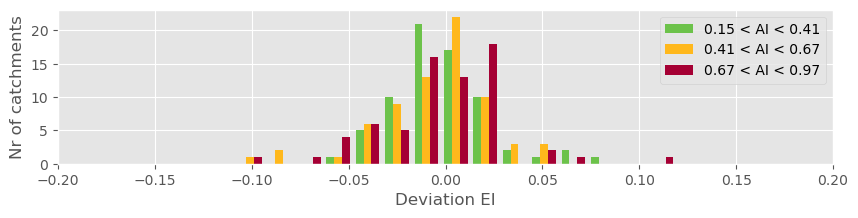

In [35]:
"Histogram EI deviations grouped by aridity (not overlapping)"

aridities = ["Wet", "Medium", "Arid"]
AI_names = [f"{min_AI:.2} < AI < {cut1_AI:.2}", f"{cut1_AI:.2} < AI < {cut2_AI:.2}", f"{cut2_AI:.2} < AI < {max_AI:.2}"]


fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(10)
EI_dev_grouped = ["", "", ""]

for a in range(len(aridities)):
    EI_dev_total = []
    if a == 0:
        catchment_list = catchment_list_wet
    elif a == 1:
        catchment_list = catchment_list_med
    elif a == 2:
        catchment_list = catchment_list_arid
        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                # print(f'Catchment nr {catchment_list[i]} has an EI deviation of {EI_dev}')
                
                EI_dev_grouped[a] = EI_dev_total
                
plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = colors2, label=AI_names)
plt.xlim(-0.2, 0.2)

plt.xlabel('Deviation EI')
plt.ylabel('Nr of catchments')


plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_aridity_notoverlapping_v1.png')   

### Histogram EI deviations grouped by seasonality timing (not overlapping)

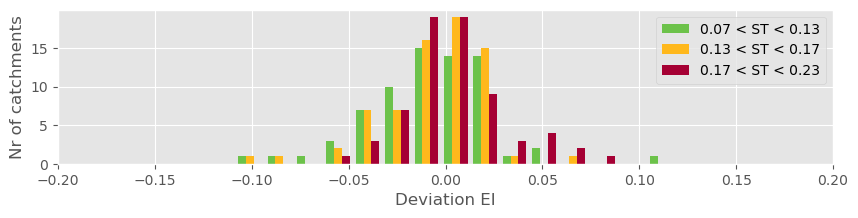

In [36]:
"Histogram EI deviations grouped by aridity (not overlapping)"

ST_names = [f"{min_ST:.1} < ST < {cut1_ST:.2}", f"{cut1_ST:.2} < ST < {cut2_ST:.2}", f"{cut2_ST:.2} < ST < {max_ST:.2}"]

fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(10)
EI_dev_grouped = ["", "", ""]

for a in range(len(ST_names)):
    EI_dev_total = []
    if a == 0:
        catchment_list = catchment_list_STlow
    elif a == 1:
        catchment_list = catchment_list_STmed
    elif a == 2:
        catchment_list = catchment_list_SThigh
        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                # print(f'Catchment nr {catchment_list[i]} has an EI deviation of {EI_dev}')
                
                EI_dev_grouped[a] = EI_dev_total
                
plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = colors2, label=ST_names)
plt.xlim(-0.2, 0.2)
plt.xlabel('Deviation EI')
plt.ylabel('Nr of catchments')

plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_ST_notoverlapping_v1.png')   

## Plot correlations

In [37]:
for k in range(len(descriptors)):
    plt.suptitle('CAMELS GB')
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(5)
    fig.set_figwidth(7)
    
    EI_dev_total = []
    des_change_total = []
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                            
                plt.plot(df_output[f'{descriptors[k]}_change {yr}'], df_output[f'EI deviation {yrsl[j]}'], '.', c=colors[j])      

    x = des_change_total
    y = EI_dev_total
    
    pearson = pearsonr(x, y)
    m, b = np.polyfit(x, y, 1)
    pearsony = np.zeros(len(x))
    
    for q in range(len(EI_dev_total)):
        pearsony[q] = m * x[q] + b
    axs.plot(x, pearsony, 'k')
                
        
    axs.set_xlabel(f"Change in {descriptors_names[k]}")
    axs.set_ylabel(f"Devation Evaporative Index")
    axs.set_title(f"CAMELS GB {descriptors_names[k]}")
    
    
    legend = [Line2D([0], [0], marker='.', color='gainsboro', label=f'{yrsl[1]}',
                       markerfacecolor=f'{colors[1]}', markersize=15),
              Line2D([0], [0], marker='.', color='gainsboro', label=f'{yrsl[2]}',
                       markerfacecolor=f'{colors[2]}', markersize=15),
             Line2D([0], [0], color='k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" ,
                       markerfacecolor='k', markersize=10)]                    

    axs.legend(handles=legend,loc='lower right')
                
    plt.savefig(f'2_Output/{output}/Results/Correlations_total{descriptors_names[k]}.png')   
    plt.close()

<Figure size 640x480 with 0 Axes>

### Plot correlations for seperate time periods

In [38]:
for k in range(len(descriptors)):
    n_tot = len(yrsl) - 1 
    fig, axs = plt.subplots(1, n_tot)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    plt.suptitle('CAMELS GB')
    for j in range(len(yrsl)):
        if j > 0:
            yr = yrsl[j]
            c = colors[j]
            n = j - 1
            
            for c in range(len(df_output)):
                axs[n].plot(df_output[f'{descriptors[k]}_change {yr}'], df_output[f'EI deviation {yr}'], '.')      

            x = df_output[f'{descriptors[k]}_change {yr}']
            y = df_output[f'EI deviation {yr}']

                
            pearson = pearsonr(x, y)

            m, b = np.polyfit(x, y, 1)
            axs[n].plot(x, m*x + b, 'k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" )
            axs[n].legend(loc='lower right')
                
                
            axs[n].set_xlabel(f"Change in {descriptors_names[k]}")
            axs[n].set_ylabel(f"Devation Evaporation Index")
            axs[n].set_title(f"Change in {descriptors_names[k]} period of {yr}")
    plt.savefig(f'2_Output/{output}/Results/Correlations_per_slice{descriptors_names[k]}.png')   
    plt.close(fig)

## Plot EI expected

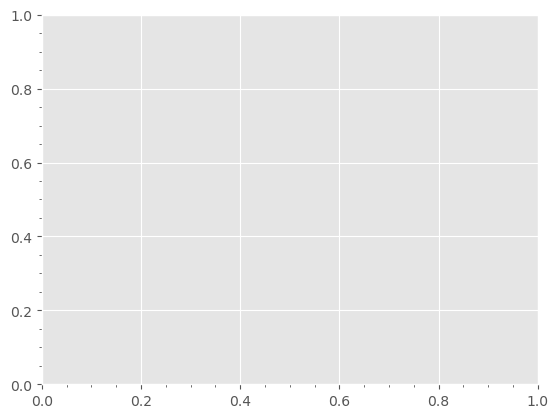

In [39]:
catchment_list = catchment_list_GB

for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv('1_Data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/timeseries/CAMELS_GB_hydromet_timeseries_'+str(catchment_list[i])+str("_19701001-20150930.csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data[3379:-273]
    
    # Compute the Makkink potential evaporation
    Eref = calc_Makkink_GB(data['temperature'],data['shortwave_rad'])
    data['Ep_MAK'] = Eref
            
    # Compute mean values    
    Ep = data['Ep_MAK'].mean()    
    T = data['temperature'].mean()
    P  = data['precipitation'].mean()
    Q  = data['discharge_spec'].mean()
        
    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  
    AI = Ep / P   
    EI = Ea / P    
        
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')
    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    data['year'] = pd.DatetimeIndex(data['date']).year  
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']].item()
        EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_MAK'].mean()    
        T = datanew['temperature'].mean()
        P  = datanew['precipitation'].mean()
        Q  = datanew['discharge_spec'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
                            
        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out, color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='.', color=c, markersize=10)
        
        if j > 0:
            c_exp = colors[j-1]
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            axs[0].plot(AI, EI_exp, marker='d', color=c, markersize=5)
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['precipitation']
        EP_ts = datanew['Ep_MAK']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
    legend_0 = [Line2D([0], [0], marker='d', color='lightgrey', label='Expected value EI',
                       markerfacecolor='k', markersize=10),
                Line2D([0], [0], marker='.', color='lightgrey', label='Actual value EI',
                       markerfacecolor='k', markersize=15)]
    
    legend_1 = [Line2D([0], [0], color=colors[0], lw=1, label=f'{yrsl[0]}'),
                Line2D([0], [0], color=colors[1], lw=1, label=f'{yrsl[1]}'),
                Line2D([0], [0], color=colors[2], lw=1, label=f'{yrsl[2]}')]
                       

    axs[0].legend(handles=legend_0,loc='lower right')
    axs[1].legend(handles=legend_1,loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments2/Expected_Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)

# Plot Budyko

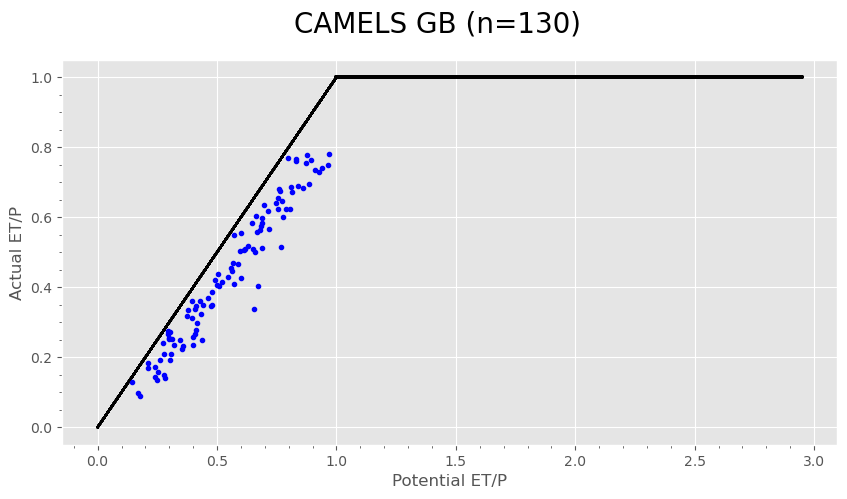

In [40]:
catchment_list = catchment_list_GB
plt.figure(figsize=(10,5)).suptitle("CAMELS GB (n=130)",fontsize=20)

for i in range(len(catchment_list)):  
    # Import data
    data = pd.read_csv('1_Data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/timeseries/CAMELS_GB_hydromet_timeseries_'+str(catchment_list[i])+str("_19701001-20150930.csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data[3379:-273]
        
    # Compute the Makkink potential evaporation
    Eref = calc_Makkink_GB(data['temperature'],data['shortwave_rad'])
    data['Ep_MAK'] = Eref
    
        
    # Mean values    
    Ep = data['Ep_MAK'].mean()    
    T = data['temperature'].mean()
    P  = data['precipitation'].mean()
    Q  = data['discharge_spec'].mean()
        
    # Compute Ea, AI, EI
    Ea = P - Q  # actual evaporation
    AI = Ep / P   # aridity index
    EI = Ea / P # evaporative index
    
    # Plot every catchment
    if Ea > 0 and AI > EI: 
        budyko_curve_x = np.arange(1, 3, 0.05)
        energy_limit_x = np.arange(0, 1.0001, 0.05)
        x = np.arange(0, 1.0001, 0.05)
        water_limit_y = 1 + budyko_curve_x*0
        energy_limit_y = energy_limit_x
        y = 1 + x*0
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.minorticks_on()
        plt.plot(energy_limit_x, energy_limit_y, c='k')
        plt.plot(budyko_curve_x, water_limit_y,c='k')
        
        plt.plot(AI, EI, marker='.', c = 'b')

plt.savefig(f'2_Output/{output}/Budyko4.png')   